# Data Preprocessing

## Import library & GPU setup

In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Allow memory growth to avoid consuming all GPU memory
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is being used")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)


GPU is being used


## Import Dataset

In [3]:
import tensorflow as tf
from keras import layers, models

# Set a random seed for reproducibility
tf.random.set_seed(42)

# Load the datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'D:\\programing\\Pneumonia\\Images\\Chest_xray\\2D\\train',
    batch_size=32,
    image_size=(128, 128),  # Resize images if needed
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'D:\\programing\\Pneumonia\\Images\\Chest_xray\\2D\\test',
    batch_size=32,
    image_size=(128, 128),  # Resize images if needed
    seed=42
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'D:\\programing\\Pneumonia\\Images\\Chest_xray\\2D\\val',
    batch_size=32,
    image_size=(128, 128),  # Resize images if needed
    seed=42
)


Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [4]:
from collections import Counter

# Initialize a Counter to count the number of images per class
class_counts = Counter()

# Iterate over the dataset and count the labels
for images, labels in train_dataset:
    class_counts.update(labels.numpy())

# Get class names from the dataset
class_names = train_dataset.class_names

# Print the count of images per class
for class_index, class_count in class_counts.items():
    class_name = class_names[class_index]
    print(f"Class '{class_name}' has {class_count} images.")

Class 'PNEUMONIA' has 3875 images.
Class 'NORMAL' has 1341 images.


In [5]:
import plotly.express as px

fig = px.bar(x=class_names, y=list(class_counts.values())[::-1])
fig.show()

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Get the first batch of images and labels
for images, labels in train_dataset.take(1):
    # Extract the first image
    first_image = images[0].numpy().astype("uint8")
    break


Text(0.5, 1.0, 'thresholded Image')

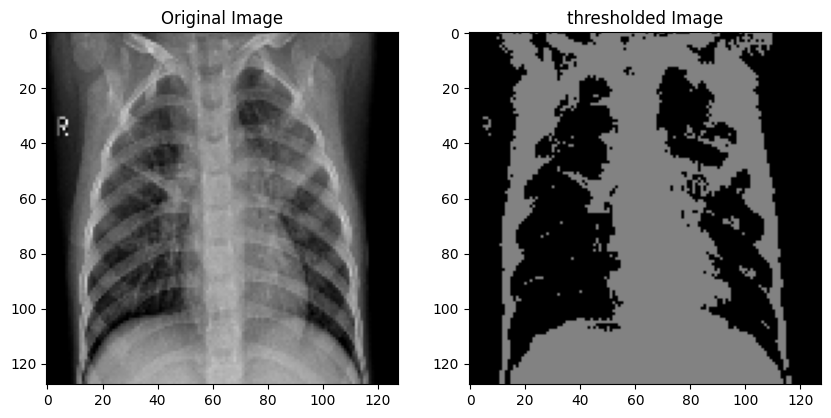

In [37]:
import cv2
# Convert the image to grayscale
gray_image = cv2.cvtColor(first_image, cv2.COLOR_RGB2GRAY)

# Apply a binary threshold
_, thresholded_image = cv2.threshold(gray_image, 100, 130, cv2.THRESH_BINARY)

# Convert the thresholded image back to RGB
thresholded_image = cv2.cvtColor(thresholded_image, cv2.COLOR_GRAY2RGB)

# Display the original and thresholded images using matplotlib
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(first_image)
plt.title('Original Image')

# Original image
plt.subplot(1, 2, 2)
plt.imshow(thresholded_image)
plt.title('thresholded Image')

## X-ray Density Segmentation

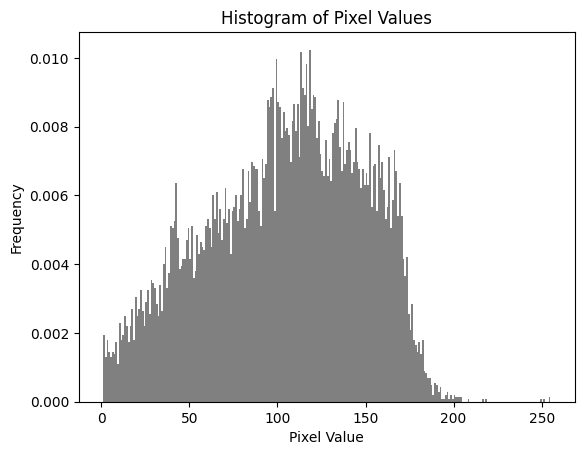

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'first_image' is already a NumPy array with dtype 'uint8'
pixel_values = first_image.flatten()

# Plot histogram
plt.hist(pixel_values[pixel_values > 0], bins=256, range=(0, 256), density=True, color='gray', alpha=1)
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


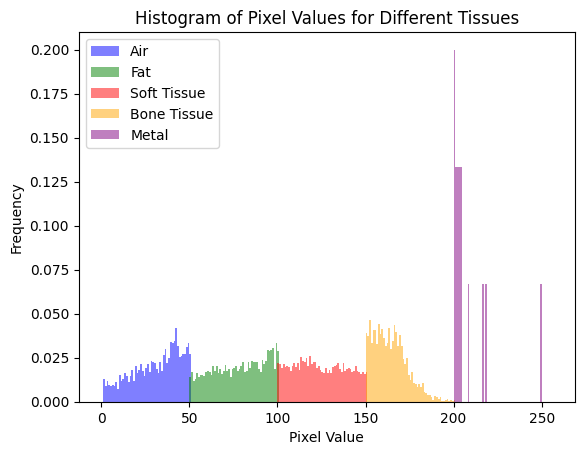

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'pixel_values' is a 1D array of pixel values from the image

# Define ranges for different tissues
air = np.where((0 <= pixel_values) & (pixel_values < 51), pixel_values, 0)
fat = np.where((50 <= pixel_values) & (pixel_values < 101), pixel_values, 0)
soft_tissue = np.where((100 <= pixel_values) & (pixel_values < 151), pixel_values, 0)
bone_tissue = np.where((150 <= pixel_values) & (pixel_values < 201), pixel_values, 0)
metal = np.where((200 <= pixel_values) & (pixel_values < 251), pixel_values, 0)

# Plot histograms
plt.hist(air[air > 0], bins=256, range=(0, 256), density=True, color='blue', alpha=0.5, label='Air')
plt.hist(fat[fat > 0], bins=256, range=(0, 256), density=True, color='green', alpha=0.5, label='Fat')
plt.hist(soft_tissue[soft_tissue > 0], bins=256, range=(0, 256), density=True, color='red', alpha=0.5, label='Soft Tissue')
plt.hist(bone_tissue[bone_tissue > 0], bins=256, range=(0, 256), density=True, color='orange', alpha=0.5, label='Bone Tissue')
plt.hist(metal[metal > 0], bins=256, range=(0, 256), density=True, color='purple', alpha=0.5, label='Metal')

# Add legend and labels
plt.title('Histogram of Pixel Values for Different Tissues')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


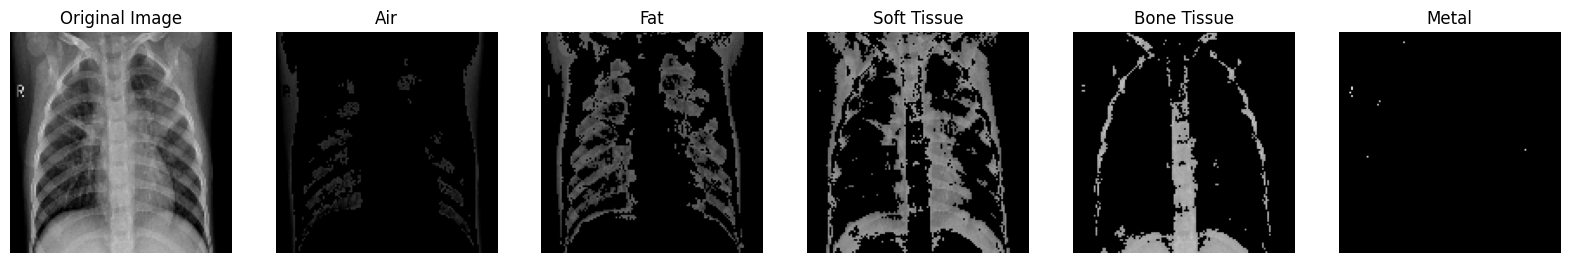

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'pixel_values' is a 1D array of pixel values from the image
# and 'first_image' is the original image

# Reshape pixel_values to match the original image shape if needed
# For example, if the original image shape is (height, width)
height, width = first_image.shape[:2]
pixel_values = pixel_values.reshape((height, width, 3))

# Define masks for different tissues
air_mask = np.where((0 <= pixel_values) & (pixel_values < 51), pixel_values, 0).astype(np.uint8)
fat_mask = np.where((51 <= pixel_values) & (pixel_values < 102), pixel_values, 0).astype(np.uint8)
soft_tissue_mask = np.where((102 <= pixel_values) & (pixel_values < 153), pixel_values, 0).astype(np.uint8)
bone_tissue_mask = np.where((153 <= pixel_values) & (pixel_values < 204), pixel_values, 0).astype(np.uint8)
metal_mask = np.where((204 <= pixel_values) & (pixel_values <= 255), pixel_values, 0).astype(np.uint8)

# Plot each mask
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

axes[0].imshow(first_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')


axes[1].imshow(air_mask, cmap='gray')
axes[1].set_title('Air')
axes[1].axis('off')

axes[2].imshow(fat_mask, cmap='gray')
axes[2].set_title('Fat')
axes[2].axis('off')

axes[3].imshow(soft_tissue_mask, cmap='gray')
axes[3].set_title('Soft Tissue')
axes[3].axis('off')

axes[4].imshow(bone_tissue_mask, cmap='gray')
axes[4].set_title('Bone Tissue')
axes[4].axis('off')

axes[5].imshow(metal_mask, cmap='gray')
axes[5].set_title('Metal')
axes[5].axis('off')

plt.show()


## Image Augmentation

In [7]:
import numpy as np
from keras.utils import img_to_array
from keras.utils.image_utils import load_img
import os
import glob

def load_images_to_array(image_dir, target_size=(128, 128)):
    # List of image file paths
    image_paths = glob.glob(os.path.join(image_dir, '*.jpeg'))

    # Initialize list to hold image arrays
    images = []

    for image_path in image_paths:
        # Load and preprocess image
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)

    # Convert list of arrays to a single NumPy array
    images_array = np.array(images)

    return images_array

# Example: flattening images with shape (128, 128, 3)
def flatten_images(image_array):
    return image_array.reshape(image_array.shape[0], -1)  # Flatten each image

In [8]:
minority_class_dir = 'D:\\programing\\Pneumonia\\Images\\Chest_xray\\2D\\train\\NORMAL'
majority_class_dir = 'D:\\programing\\Pneumonia\\Images\\Chest_xray\\2D\\train\\PNEUMONIA'
minor_images_array = load_images_to_array(minority_class_dir, target_size=(128, 128))[:500]
major_images_array = load_images_to_array(majority_class_dir, target_size=(128, 128))[:1000]
images_array = np.concatenate((minor_images_array, major_images_array), axis=0)

In [9]:
# Suppose `images` is your NumPy array with shape (num_images, 128, 128, 3)
images_flattened = flatten_images(images_array)
smote_labels = np.array([0]*len(minor_images_array) + [1]*len(major_images_array))

In [10]:
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

# Flattened images and labels
X = images_flattened
y = smote_labels

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto')

# Parameters
batch_size = 100  # Adjust batch size as needed
n_samples = len(X)
n_batches = n_samples // batch_size + 1

# Shuffle data to ensure randomness
X, y = shuffle(X, y, random_state=42)

# Containers for resampled data
X_resampled_batches = []
y_resampled_batches = []

for _ in range(n_batches):
    # Randomly select indices for the batch
    indices = np.random.choice(n_samples, batch_size, replace=False)
    
    X_batch = X[indices]
    y_batch = y[indices]
    
    # Apply SMOTE to the random batch
    X_resampled, y_resampled = smote.fit_resample(X_batch, y_batch)
    
    # Store the results
    X_resampled_batches.append(X_resampled)
    y_resampled_batches.append(y_resampled)

# Concatenate all batches
X_resampled = np.concatenate(X_resampled_batches, axis=0)
y_resampled = np.concatenate(y_resampled_batches, axis=0)

print(X_resampled.shape)  # Shape will reflect the new number of samples

(2134, 49152)


In [11]:
from numba import cuda
cuda.select_device(0)
cuda.close()

# Assuming synthetic_data and synthetic_labels are your NumPy arrays
synthetic_data = X_resampled.reshape(-1, 128, 128, 3)  # Shape should be (num_samples, height, width, channels)
synthetic_labels = y_resampled

In [12]:
Counter(synthetic_labels)

Counter({1: 1067, 0: 1067})

In [13]:
synthetic_data.shape

(2134, 128, 128, 3)